# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd

strategyArray = []
gainArray     = []
lossArray     = []

originalDataSet = pd.read_csv('dataset', sep = ',',header = None)
scaler = MinMaxScaler()

def loadDataset():    
    scaler.fit(originalDataSet.sample(frac=1).values.reshape(-1, 1))
    dataSet = scaler.transform(originalDataSet.values) 
    
    features, result = np.array(dataSet[:, :4]), np.array(dataSet[:, 4:])
    return features, result

def invertNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return scaler.inverse_transform(auxArray)[0][0]
    
def getError(value1, value2):
    return abs(invertNorm(value1) - invertNorm(value2))

Using TensorFlow backend.


# Cross validation function

In [29]:
def crossValidate(regressor, features, result, folds = 5):
    foldSize   = math.ceil(features.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(features, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(result, np.s_[sliceBegin: sliceEnd], 0)
        
        if isinstance(regressor, Sequential):
            regressor.fit(X_train, y_train, epochs = 500, verbose = 0)  
        else :
            regressor.fit(X_train, y_train)
            
        X_test = features[sliceBegin: sliceEnd]
        y_test = result[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            #print("Gain: ", invertNorm(predicted[0]), round(invertNorm(expected[0]), 14))
            #print("Loss: ", invertNorm(predicted[1]), round(invertNorm(expected[1]), 14))
            gainError += getError(predicted[0], expected[0])
            lossError += getError(predicted[1], expected[1])
            
        gainErrors.append(gainError / foldSize)
        lossErrors.append(lossError / foldSize)
        
        if isinstance(regressor, Sequential):
            regressor = setANN()

    return np.array(gainErrors), np.array(lossErrors)

In [3]:
def trainModel(strategy):   
    features, result = loadDataset()
    gainErrors, lossErrors = crossValidate(strategy, features, result)

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(lossErrors), lossErrors.std() * 2))
    
    strategyArray.append(strategy)
    gainArray.append(gainErrors)
    lossArray.append(lossErrors)

In [48]:
def setANN():
    model = Sequential()
    
    model.add(Dense(4, input_dim = 4, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dense(9, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dense(2, kernel_initializer = 'normal', activation = 'sigmoid'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Plotting functions

In [5]:
def getName(strategies):
    names = []
    for strategy in strategies:
        if isinstance(strategy, DecisionTreeRegressor):
            names.append("Decision Tree")

        if isinstance(strategy, RandomForestRegressor):
            names.append("Random Forest")

        if isinstance(strategy, MultiOutputRegressor):
            if(strategy.estimator.kernel == "rbf"):
                names.append("SVR (radial kernel)")
            else:
                names.append("SVR (linear kernel)")
        
        if isinstance(strategy, Sequential):
            names.append("ANN")
            
    return names

In [6]:
def plotGainError():
    fig, axis = plt.subplots(figsize = (10, 5))
    data       = gainArray

    axis.boxplot(data)
    axis.set_title("Gain error")
    axis.set_xticklabels(np.repeat(getName(strategyArray), 1))
    axis.set_ylabel("Absolute error")

    plt.show()

In [7]:
def plotLossError():
    fig, axis = plt.subplots(figsize = (10, 5))
    data       = lossArray

    axis.boxplot(data)
    axis.set_title("Loss error")
    axis.set_xticklabels(np.repeat(getName(strategyArray), 1))
    axis.set_ylabel("Absolute error")

    plt.show()

# Putting all together

In [49]:
gainArray = []
lossArray = []

In [50]:
regressionTree = DecisionTreeRegressor(max_depth = 9)
trainModel(regressionTree)

[2.04929836 2.19194409 2.47180216 2.49499596 2.70693251] => 2.38 (+/- 0.47)
[2.36998996 1.78365    1.63755429 2.309001   1.42954473] => 1.91 (+/- 0.74)


In [51]:
randomForest = RandomForestRegressor(max_depth = 9, n_estimators = 50)
trainModel(randomForest)

[2.15772684 2.13989599 2.23175397 2.39863275 2.59829831] => 2.31 (+/- 0.35)
[2.06068382 1.73325069 1.65919296 2.03772108 1.3099294 ] => 1.76 (+/- 0.55)


In [52]:
radialSVR = MultiOutputRegressor(SVR(kernel = "rbf", C = 1.0, gamma = 'scale', epsilon = 0.2))
trainModel(radialSVR)

[3.64756447 3.16045845 3.00286533 3.02005731 2.6991404 ] => 3.11 (+/- 0.62)
[5.6747851  6.41547278 6.11747851 6.34097421 6.59885387] => 6.23 (+/- 0.63)


In [53]:
linearSVR = MultiOutputRegressor(SVR(kernel = "linear", C = 1.0, gamma = 'scale', epsilon = 0.2))
trainModel(linearSVR)

[3.64756447 3.16045845 3.00286533 3.02005731 2.6991404 ] => 3.11 (+/- 0.62)
[5.6747851  6.41547278 6.11747851 6.34097421 6.59885387] => 6.23 (+/- 0.63)


In [54]:
trainModel(setANN())

[3.25559149 3.00483788 2.70444524 2.99699948 2.75350629] => 2.94 (+/- 0.40)
[2.11370824 1.90607457 2.16589206 1.45658709 1.35727462] => 1.80 (+/- 0.67)


# Plottin error boxplots

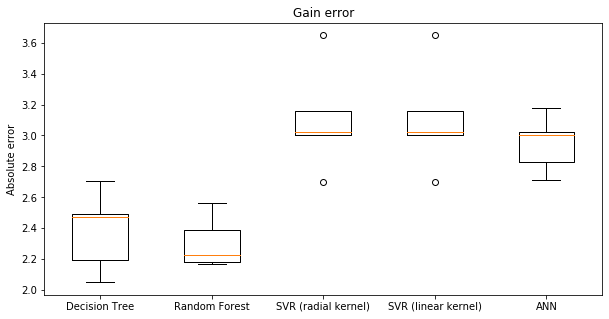

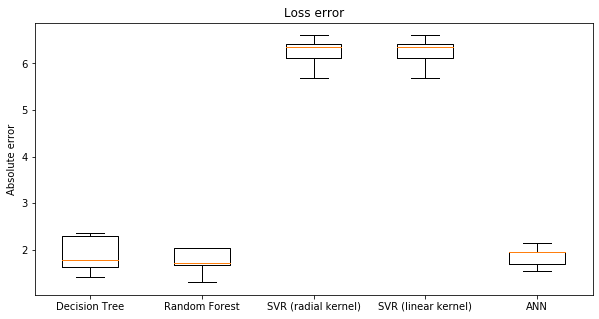

In [47]:
plotGainError()
plotLossError()